In [5]:
%load_ext autoreload
%autoreload 2

%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
from datetime import datetime
import matplotlib.pyplot as plt

import cvxpy as cv

"""
    Calculate max return optimization with max risk tolerated used as a constraint
    returns tickers distribution in the portfolio and return rate in np.array
"""

def MarkowitzOpt(mean, variance, covariance, interest_rate, min_return, max_risk):
    n = mean.size                   # Number of assets (number of stocks + interest rate)
    mu = mean.values                    # Mean returns of n assets
    #print(mu)
    Sigma = np.zeros((n,n))                 # Covariance of n assets
    counter = 0
    for i in np.arange(n):
        for j in np.arange(i, n):
            if i==j:
                Sigma[i,j] = variance[i]
            else:
                Sigma[i,j] = covariance[counter]
                Sigma[j,i] = Sigma[i,j]
                counter += 1
    w = cv.Variable(n)                         # Portfolio allocation vector
    ret = mu.T*w
    risk = cv.quad_form(w, Sigma)
    max_risk_param = cv.Parameter()
    max_risk_param.value = max_risk
    prob = cv.Problem(cv.Maximize(ret),          # Restricting to long-only portfolio
                   [cv.sqrt(cv.sum(risk)) <= max_risk,
                    cv.sum(w) == 1,
                   w >= 0])
    prob.solve(qcp=True)
    # No solution check
    if prob.status in ["infeasible", "unbounded"]:
        return np.zeros((n+1,1))
    risk = np.dot(np.power(w.value, 2), variance.ravel().reshape((len(mu),1)))
    portfolio_and_rate = np.append(w.value, sum(w.value.T*mu))
    print(f'risk: {(risk**0.5)[0]} return: {np.sum(w.value.T*mean)}')
    #print(w.value)
    return portfolio_and_rate



StockList = ['SBER','ALRS','GMKN','PLZL','RTKM','SNGS'] # Stock ticker names
max_risk = 0.03
# 4 future usage
interest_rate = 0.03/12# Fixed interest rate
min_return = 0.02# Minimum desired return


# Read stock prices data
#price = pd.read_csv('StockPrices.csv')
price = pd.read_csv('refined.txt',sep='\t')
price.index = [datetime.strptime(x,'%Y-%m-%d') for x in price['Date']]
price = price.drop('Date',1)

# Specify number of days to shift
shift = 20
# Compute returns over the time period specified by shift
shift_returns = price/price.shift(shift) - 1

# Specify filter "length"
filter_len = shift
# Compute mean and variance
shift_returns_mean = shift_returns.ewm(span=filter_len).mean()
shift_returns_var = shift_returns.ewm(span=filter_len).var()
# Compute covariances
NumStocks = len(StockList)
covariance = pd.DataFrame()
for FirstStock in np.arange(NumStocks-1):
    for SecondStock in np.arange(FirstStock+1,NumStocks):
        ColumnTitle = StockList[FirstStock] + '-' + StockList[SecondStock]
        covariance[ColumnTitle] = shift_returns[StockList[FirstStock]].ewm(span=filter_len).cov(shift_returns[StockList[SecondStock]])


# Variable Initialization
#start_date = '2006-01-03'
start_date = '2017-02-20'
index = shift_returns.index
start_index = index.get_loc(start_date)
end_date = index[-1]
end_index = index.get_loc(end_date)
date_index_iter = start_index
StockList.append('InterestRate')
distribution = DataFrame(index=StockList)
returns = Series(index=index)
real_returns = Series(index=index)
# Start Value
total_value = 1.0
real_total_value = 1.0
returns[index[date_index_iter]] = total_value
real_returns[index[date_index_iter]] = real_total_value

while date_index_iter + shift < end_index:
    date = index[date_index_iter]
    if date_index_iter > start_index:
        real_total_value += np.sum(shift_returns_mean.loc[date].T * portfolio_alloc[:-1])
    #print(real_total_value)
    portfolio_alloc = MarkowitzOpt(shift_returns_mean.loc[date], shift_returns_var.loc[date], covariance.loc[date], interest_rate, min_return, max_risk)
    distribution[date.strftime('%Y-%m-%d')] = portfolio_alloc

    # Calculating portfolio return
    total_value = total_value + portfolio_alloc[-1] 
    # Increment Date
    date_index_iter += shift
    returns[index[date_index_iter]] = total_value
    real_returns[index[date_index_iter]] = real_total_value

# Remove dates that there are no trades from returns
returns = returns[np.isfinite(returns)]
real_returns = real_returns[np.isfinite(real_returns)]


risk: 0.015786771762863132 return: 0.07753183563524173
risk: 0.013677311956670019 return: -0.015721233684499774
risk: 0.02339761882653672 return: -0.013743231593277491
risk: 0.022358257613129602 return: 0.02411561417981943
risk: 0.030001137470125783 return: -0.01397036603862077
risk: 0.034433875901000444 return: 0.009680825564447229
risk: 0.024713978596233786 return: 0.07088567059075805
risk: 0.03407233589989555 return: 0.09691721537621795
risk: 0.025095303959944727 return: 0.05276779438854274
risk: 0.02928509228136324 return: 0.08651740626510848
risk: 0.023194865310762206 return: 0.03958988262844483
risk: 0.02331922684386629 return: 0.002777120541651639
risk: 0.022708013877687814 return: 0.06044394069267224
risk: 0.029413931116872807 return: 0.08205323395069469
risk: 0.02760469147687835 return: 0.05427934040437413
risk: 0.029893636632392737 return: 0.01635551601338916
risk: 0.026049395136514737 return: 0.03540909140639933
risk: 0.030859826237147895 return: 0.06423385301167919
risk: 0.

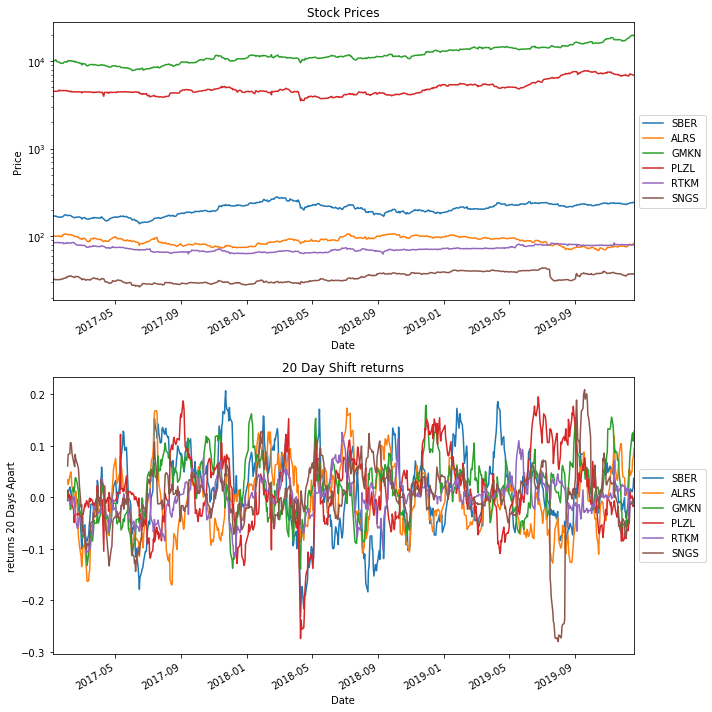

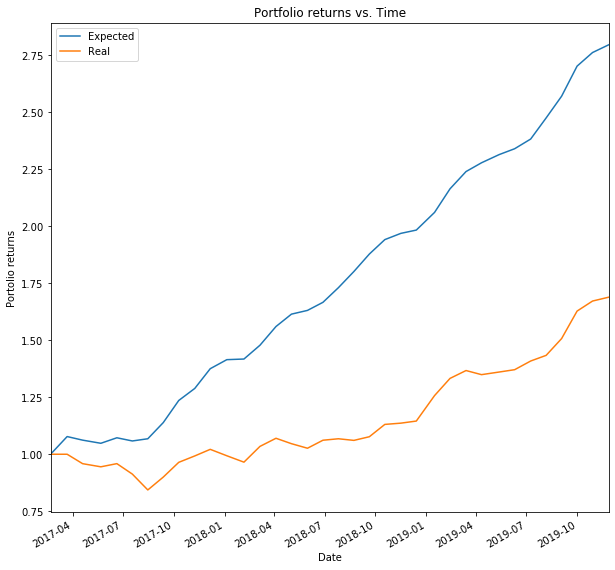

In [12]:
plt.rcParams["figure.figsize"] = (10,10)

# Plot stock prices and shifted returns
fig, axes = plt.subplots(nrows=2,ncols=1)
axes[0].set_yscale('log')
price.plot(ax=axes[0])
shift_returns.plot(ax=axes[1])
axes[0].set_title('Stock Prices')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axes[1].set_title(str(shift)+ ' Day Shift returns')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('returns ' + str(shift) + ' Days Apart')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
# Plot portfolio returns vs. time
plt.figure()
returns.plot()
real_returns.plot()
plt.xlabel('Date')
plt.ylabel('Portolio returns')
plt.title('Portfolio returns vs. Time')
plt.legend(['Expected', 'Real'])

plt.show()


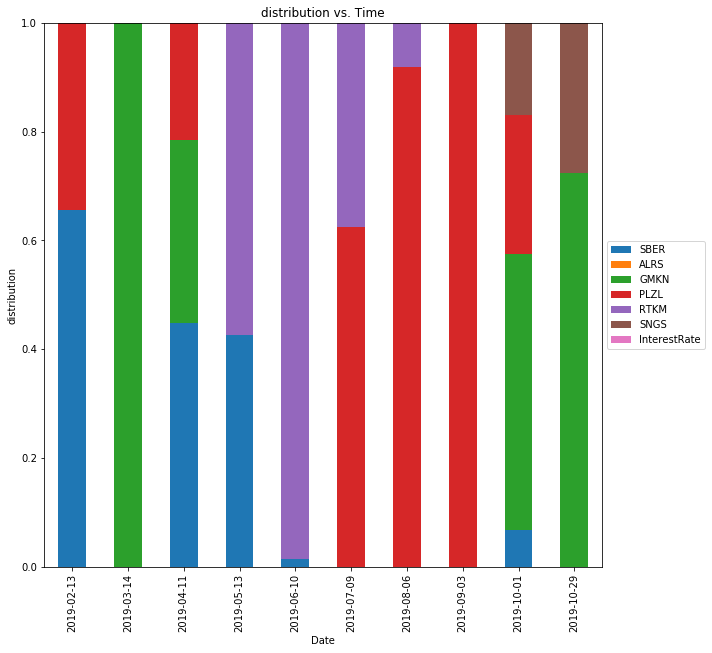

In [13]:
# Plot portfolio allocation of last 10 periods
ax = distribution.T.iloc[-10:].plot(kind='bar',stacked=True)
plt.ylim([0,1])
plt.xlabel('Date')
plt.ylabel('distribution')
plt.title('distribution vs. Time')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()